# Preparing data for modeling


In [9]:
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import scipy as sp
import pickle

In [10]:
DATASET = 'data/4_final_dataset/final_dataset.csv'
ISW_DATA = 'data/4_final_dataset/isw_final.csv'

In [11]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
df = pd.read_csv(DATASET, sep=';')
df.head(10)

## ISW Data Prep

In [ ]:
df_isw = pd.read_csv(ISW_DATA)

In [ ]:
df_isw = df_isw.drop(columns={
    'report_date',
    'title',
    'text_title',
    'main_text',
    'text_stemm',
    'keywords'
})

In [ ]:
df_isw.head(2)

In [ ]:
df_merged = pd.merge(df, 
                     df_isw, 
                     left_on='day_datetime', 
                     right_on='following_date')

In [ ]:
df_merged = df_merged.sort_values('datetime', ignore_index=True)

In [ ]:
exclude = {
    'city_resolvedAddress',
    'day_datetimeEpoch',
    'datetime',
    'day_datetime',
    'hour_datetime',
    'hour_datetimeEpoch',
    'day_sunrise',
    'day_sunset',
    'hour_preciptype',
    'hour_conditions',
    'hour_solarenergy',
    'city',
    'center_city_ua',
    'center_city_en',
    'region_alt',
    'event_region_title',
    'event_region_city',
    'event_all_region',
    'event_start',
    'event_end',
    'event_clean_end',
    'event_intersection_alarm_id',
    'event_start_time',
    'event_end_time',
    'event_start_hour',
    'event_end_hour',
    'event_day_date',
    'event_start_hour_datetimeEpoch',
    'event_end_hour_datetimeEpoch',
    'event_hour_level_event_time',
    'event_hour_level_event_datetimeEpoch',
    'region',
    'region_of_Ukraine',
    'following_date'
}

In [ ]:
df_merged = df_merged.drop(columns=exclude)

In [ ]:
df_merged.head(10)

In [ ]:
y = df_merged['is_alarm']
df_merged = df_merged.drop(columns={'is_alarm'})
df_merged = df_merged.fillna(method='ffill')

In [ ]:
nans_per_column = df_merged.isna().sum(axis=0)
nans_per_column

In [22]:
df_merged.shape

(210979, 32)

## Chunking the Data & Concatenating TF-IDF Vectors to the Final Dataset

In [23]:
tfidf = pickle.load(open('data/3_isw_vectorized_data/tfidf_transformer.pkl', 'rb'))
cv = pickle.load(open('data/3_isw_vectorized_data/cv.pkl', 'rb'))

In [24]:
chunks = np.array_split(df_merged, 100)

In [25]:
X = sp.sparse.csr_matrix((0, 9222), dtype=float)

for chunk in chunks:
    cv_vector = cv.transform(chunk['text_lemm'].values.astype('U'))
    tfidf_vec = tfidf.transform(cv_vector)
    chunk = chunk.drop(columns={'text_lemm'})
    chunk_csr = sp.sparse.csr_matrix(chunk.values.astype(float))
    chunk_merged = sp.sparse.hstack((chunk_csr, tfidf_vec), format='csr')
    X = sp.sparse.vstack((X, chunk_merged))

In [26]:
X.shape

(210979, 9222)

## Separating Data  
#### using `sklearn.model_selection.TimeSeriesSplit`

In [27]:
tscv = TimeSeriesSplit()

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index, :], X[test_index, :]
    y_train, y_test = y[train_index], y[test_index]

In [28]:
X_train.shape

(175816, 9222)

In [29]:
X_test.shape

(35163, 9222)

# Training Models

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

### Model 1 | Logistic Regression

In [ ]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

### Model 2 | Support Vector Machines

In [ ]:
lsvc = LinearSVC(max_iter=10000)
lsvc.fit(X_train, y_train)

### Model 3 | Stochastic Gradient Descent

### Model 4 | Forests of randomized trees

In [ ]:
randomforest =  RandomForestClassifier(n_estimators=1000)
randomforest.fit(X_train, y_train)

### Model 5 | ...

### Model 6 | ...

# Model Evaluation

In [38]:
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay

### Model 1 

In [62]:
y_predicted_logreg = logreg.predict(X_test)
np.mean(y_predicted_logreg == y_test)

0.9226459630861985

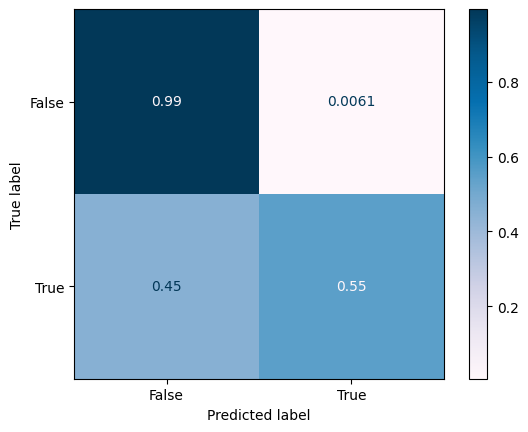

In [65]:
ConfusionMatrixDisplay.from_predictions(y_test, y_predicted_logreg, 
                                        im_kw={'cmap':'PuBu'}, 
                                        normalize='true')
plt.show()

### Model 2 

In [59]:
y_predicted_lsvc = lsvc.predict(X_test)
np.mean(y_predicted_lsvc == y_test)

0.9304951227142166

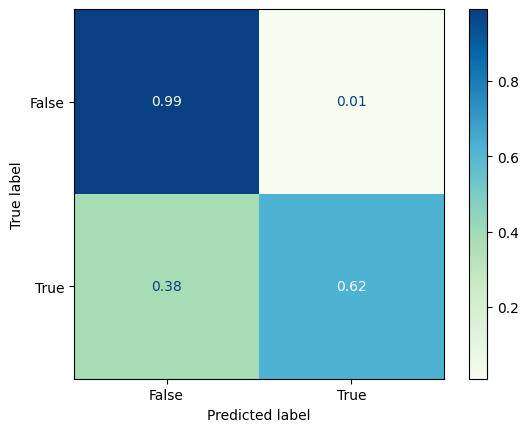

In [66]:
ConfusionMatrixDisplay.from_predictions(y_test, y_predicted_lsvc, 
                                        im_kw={'cmap':'GnBu'}, 
                                        normalize='true')
plt.show()

### Model 3

### Model 4

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_predicted_randomforest, 
                                        im_kw={'cmap':'GnBu'}, 
                                        normalize='true')
plt.show()

### Model 5

### Model 6